In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gpytorch
import torch
import pandas as pd
import importlib

# import GPGridSearch and utils
from dipper.model_utils.GPGridSearch import GPGridSearch
from dipper.data_utils.utils import *
from dipper.model_utils.utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data and inject an anomaly

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


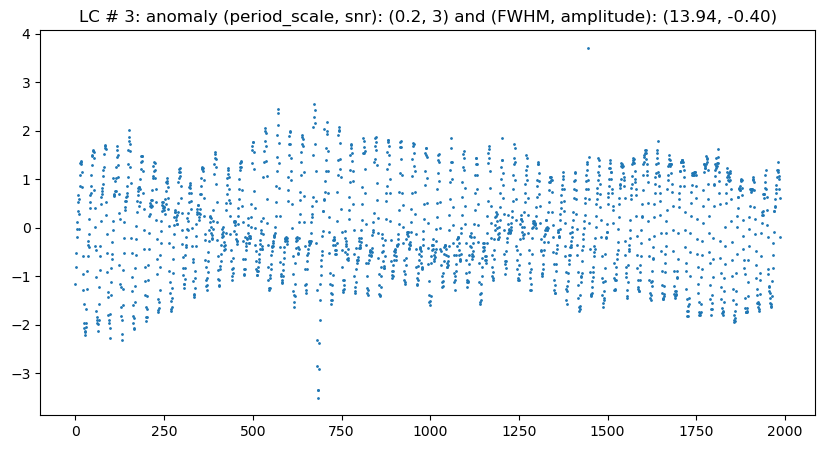

Anomaly locations:
[1367]


In [2]:
# Data and anomaly parameters
file_number = 3
shape = "gaussian"
period_scale = 0.2
snr = 3
loc = 1367

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    period_scale=period_scale,
    snr=snr,
    anomaly_idx=[loc]
)

# Narrow in to boundary right +500 and -500 inidices from loc, and sparisfy by 10
steps = np.array(range(len(x)))
# mask = np.logical_and(steps > loc - 300, steps < loc + 300)
mask = np.ones(len(x), dtype=bool)
x = x[mask][::2]
y = y[mask][::2]
y_err = y_err[mask][::2]

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
# for i in range(len(anomaly_locs)):
#     plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5, label='Anomaly center')
# plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
# for i in anomaly_locs: print(x[int(i)])

# Perform grid search to find most anomalous interval

In [3]:
# Hyperparameters
min_anomaly_len = int(1 / (2 * np.median(np.diff(x))))  # Nyquist frequency
max_anomaly_len = int(0.1 * len(x))  # Max 10% of total time steps
window_slide_step = 30
window_size_step = 30
assume_independent = True
which_metric = 'mll'
initial_lengthscale = 0.5
training_iterations = 50
filename = f'../results/test.txt'

gp_detector = GPGridSearch(
    x,
    y,
    y_err,
    min_anomaly_len=min_anomaly_len,
    max_anomaly_len=max_anomaly_len,
    window_slide_step=window_slide_step,
    window_size_step=window_size_step,
    assume_independent=assume_independent,
    which_metric=which_metric,
    initial_lengthscale=initial_lengthscale,
)

print("Number of steps:", gp_detector.num_steps, "min anomaly length:", min_anomaly_len, "max anomaly length:", max_anomaly_len)
print("Number of anomaly intervals:", len(gp_detector.intervals))
print("First 10 anomaly intervals:", gp_detector.intervals[:10])

Number of steps: 1987 min anomaly length: 11 max anomaly length: 198
Number of anomaly intervals: 441
First 10 anomaly intervals: [(0, 11), (0, 41), (0, 71), (0, 101), (0, 131), (0, 161), (0, 191), (30, 41), (30, 71), (30, 101)]


In [4]:
# Find the best interval
gp_detector.find_anomalous_interval(device=device, training_iterations=training_iterations, filename=filename, silent=False)
print("Best interval:", gp_detector.best_interval, "min metric:", gp_detector.min_metric)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Anomaly interval: 0-11, sum metric over the interval: -14.69062614440918
Anomaly interval: 0-11, mean metric over the interval: -1.335511565208435


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Anomaly interval: 0-41, sum metric over the interval: -72.33724975585938
Anomaly interval: 0-41, mean metric over the interval: -1.764323115348816
Anomaly interval: 0-71, sum metric over the interval: -124.18486022949219
Anomaly interval: 0-71, mean metric over the interval: -1.7490825653076172
Anomaly interval: 0-101, sum metric over the interval: -171.59129333496094
Anomaly interval: 0-101, mean metric over the interval: -1.6989237070083618
Anomaly interval: 0-131, sum metric over the interval: -216.87290954589844
Anomaly interval: 0-131, mean metric over the interval: -1.6555184125900269
Anomaly interval: 0-161, sum metric over the interval: -268.0887451171875
Anomaly interval: 0-161, mean metric over the interval: -1.6651475429534912
Anomaly interval: 0-191, sum metric over the interval: -314.73626708984375
Anomaly interval: 0-191, mean metric over the interval: -1.6478338241577148
Anomaly interval: 30-41, sum metric over the interval: -17.142908096313477
Anomaly interval: 30-41, m

### Analyze

   start  end    metric
0      0   11 -1.336336
1      0   41 -1.764583
2      0   71 -1.749002
3      0  101 -1.698969
4      0  131 -1.655492
Best intervaL:     start  end    metric
21     90  101 -2.856168


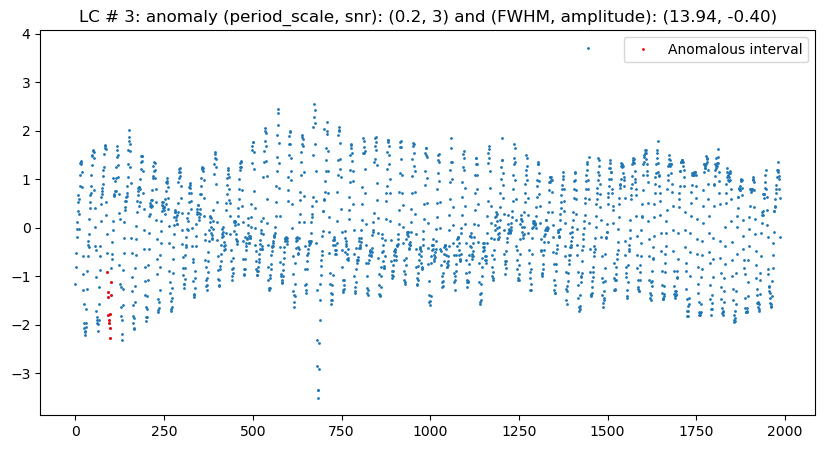

In [18]:
# results are stored in a txt file, with header: start,end,metric
data = pd.read_csv(filename, header=0, sep=",")
print(data.head())

# find the best metric start and end interval
best_metric = data["metric"].min()
best_interval = data[data["metric"] == best_metric]
start = int(best_interval["start"].values[0])
end = int(best_interval["end"].values[0])
print(f"Best intervaL: {best_interval}")

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
plt.plot(range(start, end), y[start:end], '.', color='r', markersize=2, label='Anomalous interval')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

In [19]:
# Print the metric for the range with the center of the anomaly in the middle
print("Metric for the range overlapping the anomaly center:")
anomaly_overlap = data[(data["start"] <= loc) & (data["end"] >= loc)]
best_anomaly_metric = anomaly_overlap["metric"].max()
best_anomaly_interval = anomaly_overlap[anomaly_overlap["metric"] == best_anomaly_metric]
print(best_anomaly_interval)

Metric for the range overlapping the anomaly center:
     start   end    metric
304   1290  1391 -1.295612
